# Geospatial Clustering for Food Delivery Base Optimization

This notebook demonstrates how **spatial clustering** can be used to recommend optimal **service base locations** for a city-wide delivery scenario using point locations (e.g., restaurant/demand points).

## Methods
- **K-Means**
- **DBSCAN**
- **Hierarchical Clustering**

## Outputs
- Cluster assignments and comparison
- Recommended base locations (cluster representatives/centroids)
- Map visualizations of clusters and suggested bases

> **Academic note:** Adapted from coursework completed during my Master’s in Geomatics Engineering (University of Calgary). Shared for portfolio and learning purposes. No course handouts, rubrics, or solution keys are included.


## Overview:


Imagine you are a data scientist working for a rapidly growing food delivery company operating in a bustling metropolis. With the increasing demand for food delivery services, the company is keen on optimizing its operations to ensure efficient and timely delivery to customers across the city. To achieve this goal, the company is looking to strategically establish bases for its fleet of motorbikes, which serve as the backbone of its delivery network.

**Objective:**
Your objective is to assist the food delivery company in determining the optimal locations for establishing bases within the city. By analyzing a dataset containing the locations of various restaurants, your task is to identify clusters of restaurants and recommend suitable locations for the company's delivery bases.

## Part 1: Data Preparation

### Restaurant Location Data Collection

Restaurant location data was obtained from **OpenStreetMap (OSM)**, a global, open-source geographic database maintained by a community of contributors. OpenStreetMap provides detailed and continuously updated information about points of interest, including businesses and amenities.

The data was programmatically retrieved using the **OSMnx** Python library, which enables direct querying of OpenStreetMap features based on geographic boundaries and attribute tags. The study area was defined using city-level boundaries, and restaurant locations were filtered using the OpenStreetMap tag:

`{"amenity": "restaurant"}`

This query returned georeferenced point features representing restaurant locations within the selected city. The resulting dataset includes latitude–longitude coordinates and associated attributes, making it well-suited for spatial analysis, clustering, and map-based visualization.

Using OpenStreetMap via OSMnx ensures reproducibility, transparency, and access to an up-to-date dataset without reliance on proprietary sources.


In [ ]:
# import required libraries
import osmnx as ox
import geopandas as gpd


# Define the city or region of interest
city = "Rome, Italy"

# Define the tags to filter for restaurant features
tags = {"amenity": "restaurant"}

# fetch the tourist attractions
restaurants = ox.features.features_from_place(city, tags=tags)


In [ ]:
######### This is a test-cell that print the first few rows of the restaurants DataFrame #########

restaurants.head(3)

geometry addr:city addr:housenumber  \
element id                                                            
node    252440275  POINT (12.474 41.888)      Roma               53   
        252601050  POINT (12.499 41.896)      Roma              33c   
        257355946  POINT (12.474 41.895)      Roma               88   

                  addr:postcode                  addr:street     amenity  \
element id                                                                 
node    252440275         00153          Viale di Trastevere  restaurant   
        252601050         00184  Via di San Martino ai Monti  restaurant   
        257355946         00186            Largo dei Librari  restaurant   

                   cuisine                           name  \
element id                                                  
node    252440275    pizza              Pizzeria ai Marmi   
        252601050  chinese                  Sichuan Haozi   
        257355946  italian  Dar filettaro a Santa Barbara   

                                   opening_hours            phone  ...  \
element id                                                         ...   
node    252440275              Th-Tu 18:30-02:30   +39 06 5800919  ...   
        252601050  Mo-Su 11:00-15:00,17:30-23:00  +39 06 481 4425  ...   
        257355946                   Mo-Sa 17:30+   +39 06 6864018  ...   

                  parking parking:fee parking:wheelchair buildingpart  \
element id                                                              
node    252440275     NaN         NaN                NaN          NaN   
        252601050     NaN         NaN                NaN          NaN   
        257355946     NaN         NaN                NaN          NaN   

                  diet:omnivore rooms operator:type landuse indoor leisure  
element id                                                                  
node    252440275           NaN   NaN           NaN     NaN    NaN     NaN  
        252601050           NaN   NaN           NaN     NaN    NaN     NaN  
        257355946           NaN   NaN           NaN     NaN    NaN     NaN  

[3 rows x 223 columns]

### Step 2: Data Cleaning and Preparation

The downloaded restaurant dataset was cleaned to ensure it was suitable for spatial clustering. Only relevant attributes (`cuisine` and `geometry`) were retained to reduce noise and focus on spatial analysis.

Non-point geometries were removed so that all records represented individual restaurant locations, which is required for clustering algorithms. The index was reset for consistency, and rows with missing values were excluded to avoid errors during analysis.

The resulting dataset contains clean, georeferenced point features ready for clustering and visualization.


In [ ]:
# Keep relevant columns and filter points
restaurants_cleaned = restaurants[["cuisine", "geometry"]].copy()
restaurants_cleaned = restaurants_cleaned[restaurants_cleaned.geometry.type == "Point"]
restaurants_cleaned = restaurants_cleaned.reset_index(drop=True)
restaurants_cleaned.dropna(subset=["cuisine", "geometry"], inplace=True)


In [ ]:
######### This is a test-cell that print the first few rows of the restaurants_cleaned DataFrame #########

restaurants_cleaned.head(3)

cuisine               geometry
0    pizza  POINT (12.474 41.888)
1  chinese  POINT (12.499 41.896)
2  italian  POINT (12.474 41.895)

### Step 3: Data Preparation

Before performing clustering analysis, the spatial data was prepared by converting geometric features into numeric coordinates. Latitude and longitude values were extracted from the geometry column to provide explicit spatial inputs required by distance-based clustering algorithms.

After extracting the coordinate values, the geometry column was removed, resulting in a simplified dataset optimized for clustering and analysis.


In [ ]:
# Note: For geodetic coordinates, X is longitude and Y is latitude
# Extract coordinates
restaurants_cleaned["longitude"] = restaurants_cleaned.geometry.x
restaurants_cleaned["latitude"] = restaurants_cleaned.geometry.y
restaurants_cleaned.drop(columns=["geometry"], inplace=True)

In [ ]:
######### This is a test-cell that print the first few rows of the restaurants_cleaned DataFrame #########

restaurants_cleaned.head(3)

cuisine  longitude   latitude
0    pizza  12.473790  41.888263
1  chinese  12.499455  41.895814
2  italian  12.473696  41.894671

## Part 2: Perform K-Means Clustering


### Step 1: Performing K-Means Clustering with random parameters

K-Means clustering was applied to the restaurant location dataset using the `KMeans` implementation from `sklearn.cluster`. An initial set of cluster parameters was selected to explore how restaurant locations group spatially and to establish a baseline clustering result.

Key parameters included the number of clusters (`n_clusters`), centroid initialization method (`k-means++`), maximum iteration limit, number of initializations, and a fixed random seed to ensure reproducibility. The model was fit using latitude and longitude coordinates as inputs.

After fitting the model, cluster centroids were extracted and interpreted as candidate base locations, representing central points within each spatial cluster.


In [ ]:
import warnings
from sklearn.cluster import KMeans

# Suppress warnings
warnings.filterwarnings('ignore')

# Define K-Means parameters
kmeans_params = {
    "n_clusters": 5,          # Number of clusters
    "init": "k-means++",      # Initialization method for centroids
    "max_iter": 300,          # Maximum number of iterations
    "n_init": 10,             # Number of runs with different centroid seeds
    "random_state": 0         # Random seed for reproducibility
}

# Fit K-Means model
kmeans = KMeans(**kmeans_params)
kmeans.fit(restaurants_cleaned[["latitude", "longitude"]])

KMeans(n_clusters=5, n_init=10, random_state=0)

### Step 2: Determining the Optimal Number of Clusters for K-Means clustering

To identify an appropriate number of clusters for K-Means, both the **elbow method** and **silhouette score** were used to evaluate clustering performance across a range of cluster counts.

K-Means models were fit iteratively using different values of `n_clusters`, and silhouette scores were computed to measure cluster cohesion and separation. The optimal number of clusters was selected based on the highest silhouette score, supported by visual inspection of the elbow curve.

The silhouette scores were visualized to compare clustering quality across different cluster counts, with the selected optimal value highlighted to guide model selection.

![Silhouette Score Plot](images/output.png)


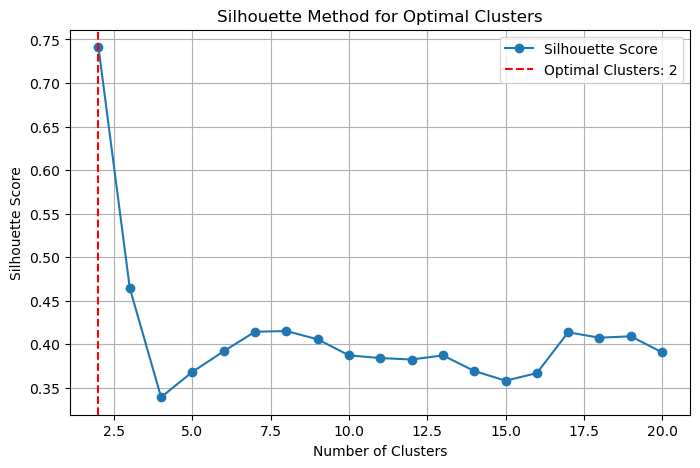

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Step 1: Specify the range of cluster numbers to evaluate
n_clusters_range = range(2, 21)  # From 2 to 20 clusters

# Step 2: Calculate silhouette scores for each number of clusters
silhouette_scores = []
for k in n_clusters_range:
    # Initialize and fit KMeans
    kmeans = KMeans(n_clusters=k, random_state=0).fit(restaurants_cleaned[["latitude", "longitude"]])
    labels = kmeans.labels_
    
    # Calculate silhouette score
    score = silhouette_score(restaurants_cleaned[["latitude", "longitude"]], labels, metric='euclidean')
    silhouette_scores.append(score)

# Step 3: Determine the best number of clusters
optimal_clusters = n_clusters_range[np.argmax(silhouette_scores)]

# Step 4: Visualize silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(n_clusters_range, silhouette_scores, marker='o', label="Silhouette Score")
plt.axvline(optimal_clusters, ls='--', color="red", label=f"Optimal Clusters: {optimal_clusters}")
plt.title('Silhouette Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.show()

### Step 3: Performing K-Means Clustering and Visualizing Results

To understand how cluster structure changes with different values of `n_clusters`, K-Means was executed across the selected cluster range and the results were visualized for comparison. For each run, restaurant locations were plotted using their assigned cluster labels, and the corresponding cluster centroids were overlaid as representative base locations.

These visualizations helped validate whether clusters were spatially meaningful (compact and well-separated) and supported selection of a practical cluster count beyond metrics alone.

![Plot](images/output_2.png)


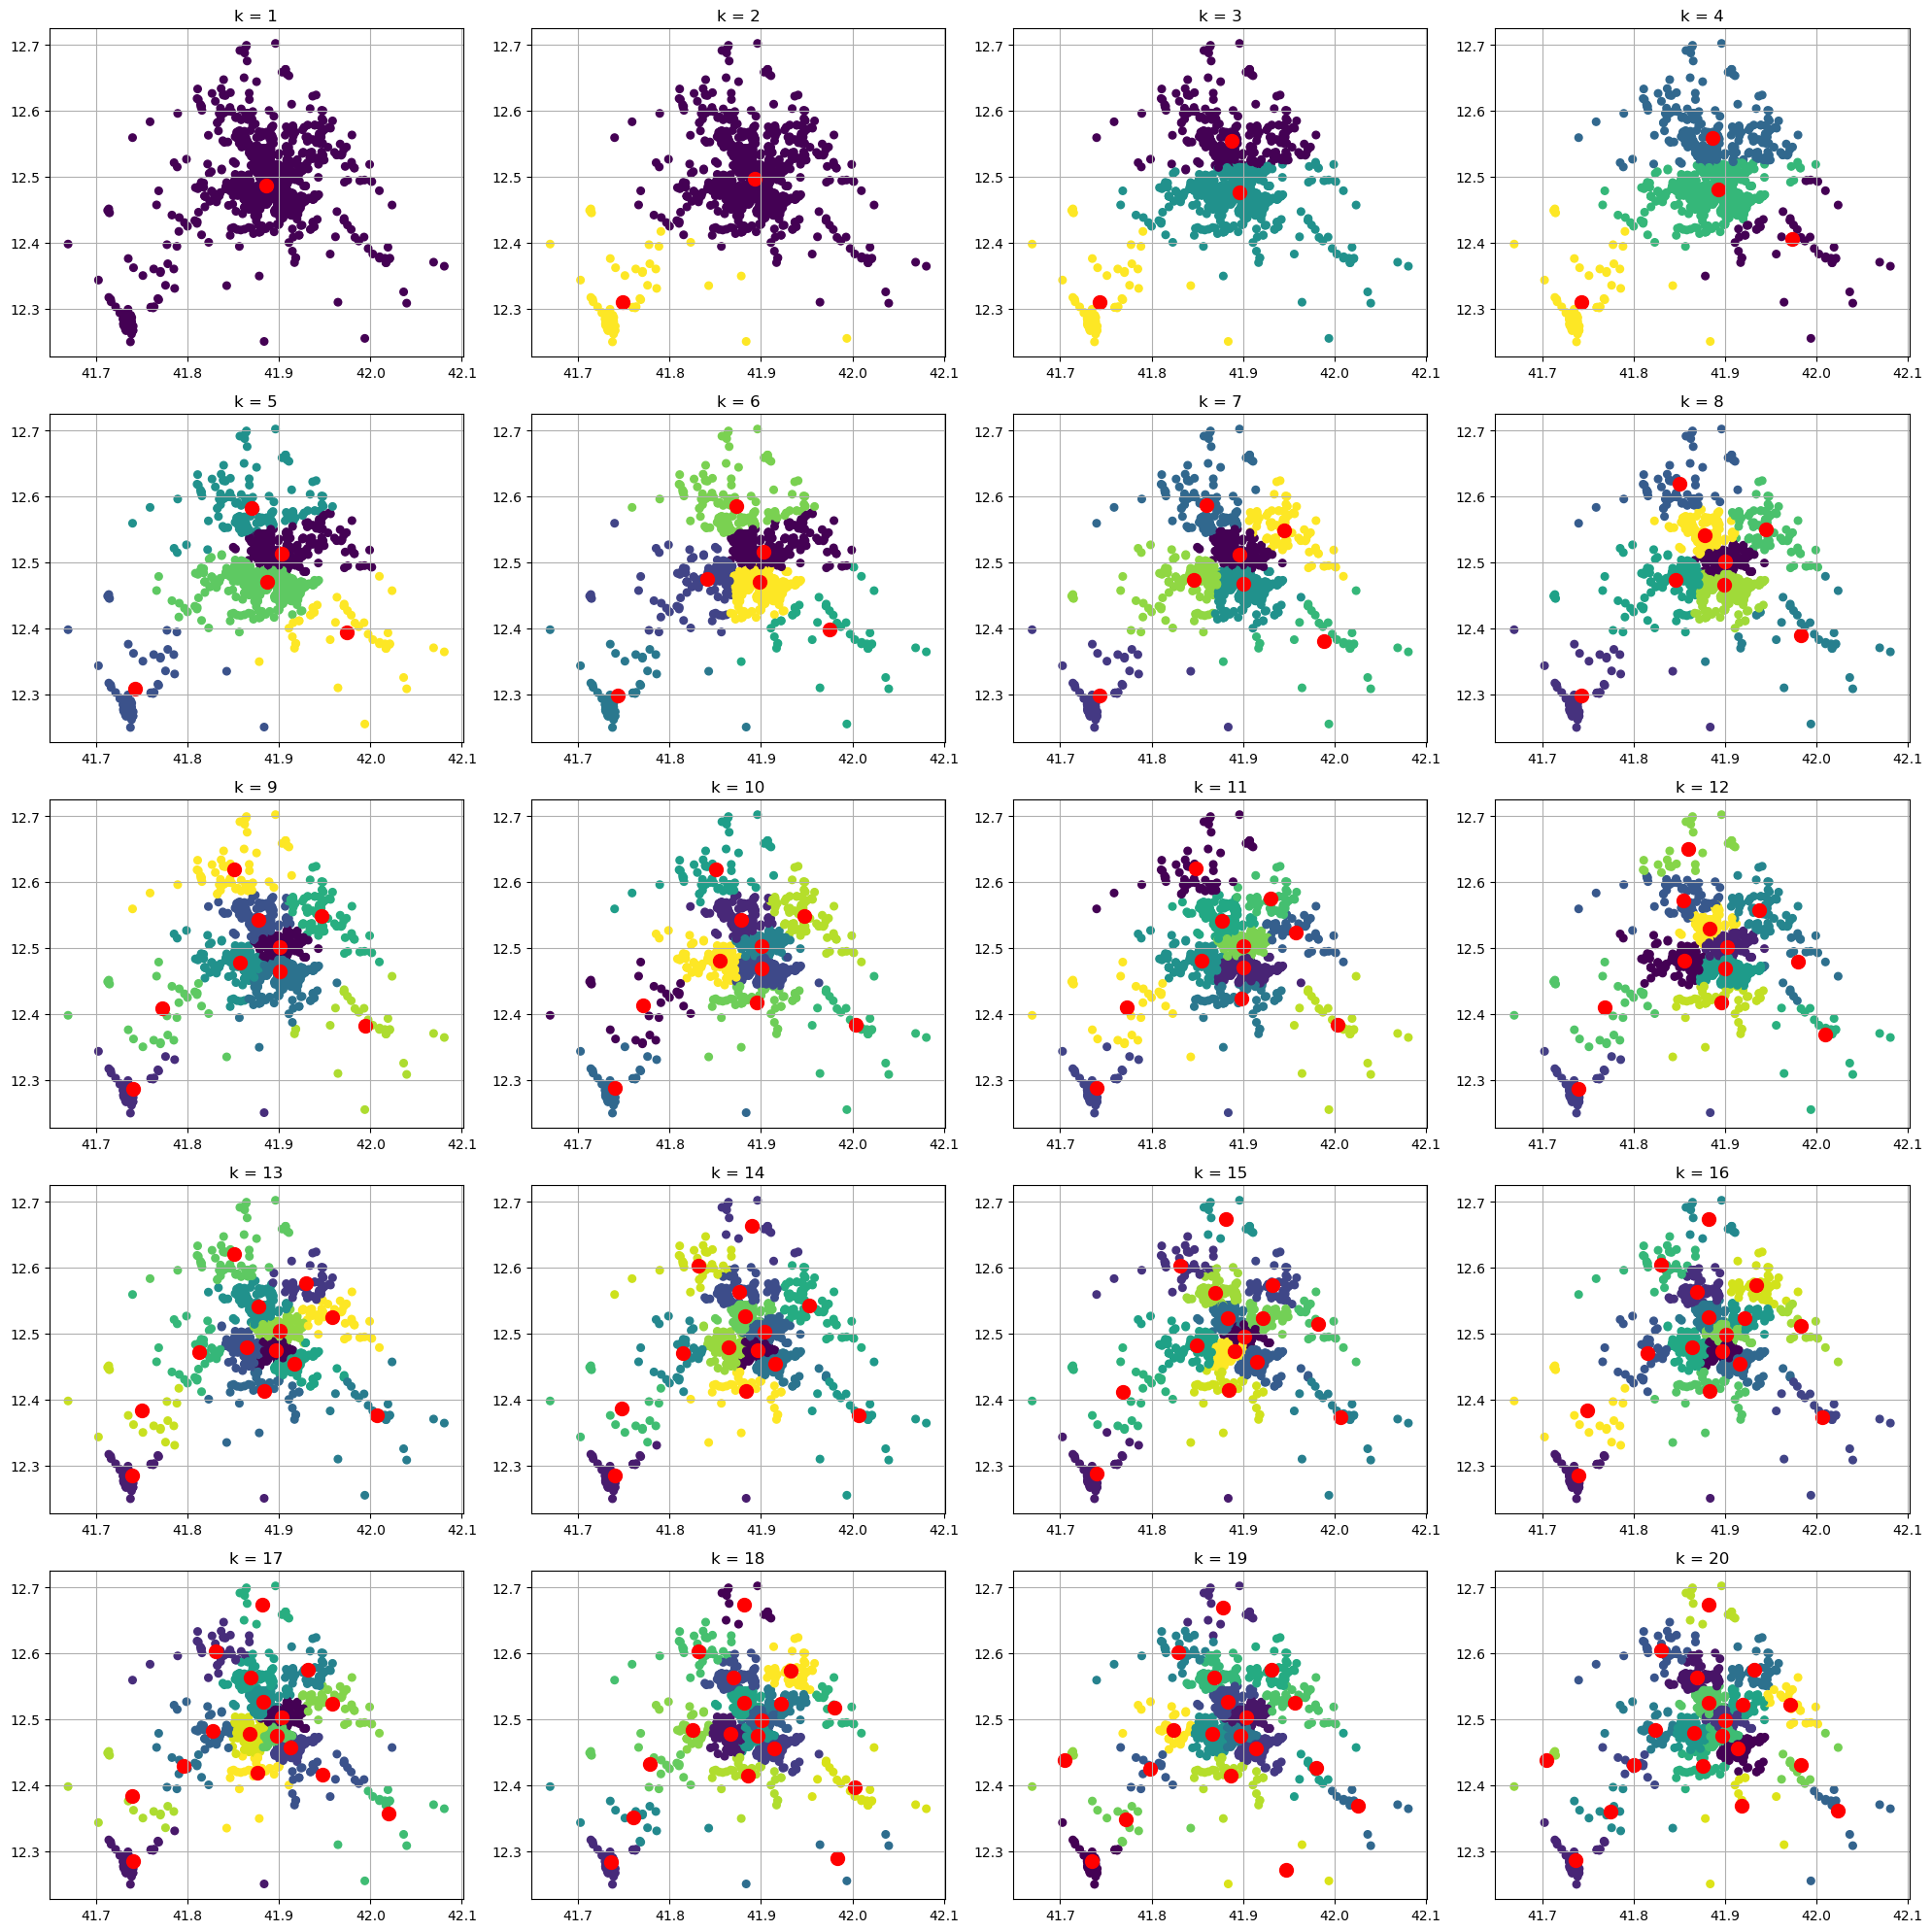

In [ ]:
# perform k means clustering from 1 cluster to 20 and plot the results with plt each cluster has same color
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

X = restaurants_cleaned[['latitude', 'longitude']]

# plot the clusters
fig, ax = plt.subplots(5, 4, figsize=(20, 20))
ax = ax.ravel()
centers = []
# fit the model for each number of clusters
for i in range(1, 21):
    model = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    model.fit(X)
    # save the cluster centers
    centers.append(model.cluster_centers_)
    # predict the cluster for each data point
    y = model.predict(X)
    # plot the data points with color based on the cluster they belong to
    ax[i-1].scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=30, cmap='viridis')
    # plot the centers of the clusters
    ax[i-1].scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], s=100, c='red')
    # set the title
    ax[i-1].set_title('k = '+str(i))
    ax[i-1].grid(True)
plt.tight_layout()
plt.show()

### Step 4:  Visualizing Results on Folium Map

To finalize the K-Means analysis, the model was fit using the **optimal number of clusters** selected from the silhouette evaluation. Cluster labels were added to each restaurant record, and the corresponding cluster centroids were computed as representative base locations.

The results were then visualized using a **Folium** interactive map centered on the study area. Restaurants were displayed as circle markers colored by their assigned cluster, and centroids were added as separate markers to clearly show the suggested base locations.

![Plot](images/map.png)


In [ ]:
import folium
import seaborn as sns
from sklearn.cluster import KMeans

# 1. Initialize K-Means with optimal clusters
optimal_k = 2  # My optimal cluster count
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(restaurants_cleaned[["latitude", "longitude"]])

# 2. Add cluster labels to DataFrame
restaurants_cleaned["cluster_label_kmeans"] = kmeans.labels_

# 3. Add centroids to DataFrame
centroids = kmeans.cluster_centers_
restaurants_cleaned["cluster_centroids_kmeans"] = restaurants_cleaned["cluster_label_kmeans"].apply(
    lambda label: tuple(centroids[label])  # Store as (lat, lon) tuple
)

# 4. Create Folium map
map_center = [
    restaurants_cleaned["latitude"].mean(),
    restaurants_cleaned["longitude"].mean()
]
m = folium.Map(location=map_center, zoom_start=11)

display(restaurants_cleaned.head(5))

# 5. Plot restaurants with cluster colors
color_list = sns.color_palette("hls", optimal_k).as_hex()
for _, row in restaurants_cleaned.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=3,
        color=color_list[row["cluster_label_kmeans"]],
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

# 6. Plot centroids as circle markers with cluster number in tooltip
for cluster_idx, centroid in enumerate(centroids):
    folium.Marker(
        location=[centroid[0], centroid[1]],
        icon=folium.Icon(color="blue", icon="circle", prefix="fa"),
        tooltip=f"Centroid of Cluster: {cluster_idx}"
    ).add_to(m)

# Display the map
m

cuisine  longitude   latitude  cluster_label_kmeans  \
0              pizza  12.473790  41.888263                     0   
1            chinese  12.499455  41.895814                     0   
2            italian  12.473696  41.894671                     0   
3  pizza;steak_house  12.476983  41.853427                     0   
5            italian  12.514332  41.875315                     0   

                  cluster_centroids_kmeans  
0  (41.89361822860892, 12.496496988188976)  
1  (41.89361822860892, 12.496496988188976)  
2  (41.89361822860892, 12.496496988188976)  
3  (41.89361822860892, 12.496496988188976)  
5  (41.89361822860892, 12.496496988188976)

## Question 1:

Based on your analysis of the silhouette scores and the visualization results you observed, which number of clusters do you recommend for the food delivery company, and why?


**Answer to Question 1:**

Based on the silhouette score analysis and geographic distribution of restaurants, **I recommend 2 clusters** for the food delivery company. Here’s the justification:

---

#### **1. Silhouette Score and Cluster Quality**
- The **highest silhouette score** was achieved at **2 clusters**, indicating optimal separation between clusters and cohesion within clusters. This suggests:
  - **Well-defined clusters**: Restaurants within each cluster are geographically close, minimizing intra-cluster distances.
  - **Distinct separation**: The two clusters are spaced sufficiently apart to avoid overlap, ensuring efficient delivery route planning.

---

#### **2. Geographic Practicality**
The city’s restaurant distribution likely aligns with **two dominant regions** (e.g., downtown and suburban areas). Two clusters:
- **Align with natural urban divisions**: For example, clustering around dense downtown restaurants and suburban neighborhoods.
- **Balance coverage and efficiency**: Fewer clusters would risk under-serving dispersed areas, while more clusters would lead to redundant bases and increased operational costs.
- **Centralized centroids**: The K-Means centroids (delivery bases) would lie at the heart of these clusters, minimizing average delivery distances.

---

#### **3. Impact of K-Means Parameters**
The stability and reliability of the clustering results depend on carefully chosen parameters:
1. **`init="k-means++"`**:  
   - Ensures initial centroids are spread out intelligently, avoiding poor cluster formations.  
   - Critical for cities with uneven restaurant density (e.g., avoiding bases in sparse areas).  

2. **`max_iter=300`**:  
   - Allows sufficient iterations for the algorithm to converge, even in regions with complex spatial distributions.  

3. **`n_init=10`**:  
   - Reduces variability by running the algorithm multiple times with randomized initializations.  
   - Ensures consistency in identifying the same two optimal clusters across runs, critical for long-term operational planning.  

---

#### **4. Why Not More Clusters?**
While a higher number of clusters (e.g., 3–4) might marginally improve silhouette scores, they would:
- **Over-segment the city**: Creating small clusters with few restaurants, leading to underutilized delivery bases.  
- **Increase operational complexity**: Managing more bases requires additional staffing, vehicles, and logistics.  
- **Diminishing returns**: Marginal score gains do not justify added complexity.

---

#### **Conclusion**
**Two clusters** strike the best balance between statistical validity (silhouette score) and practical logistics. The geographic distribution of restaurants, combined with stable parameter choices (`k-means++`, `n_init=10`), ensures that delivery bases are placed in centralized, high-demand zones. This setup minimizes delivery times, reduces costs, and aligns with the city’s natural restaurant density patterns.

---


## Part 3: Perform DBSCAN Clustering


### Step 1: Performing DBSCAN Clustering with random parameters

DBSCAN clustering was applied to the cleaned restaurant location dataset using exploratory (random) parameter values for `eps` and `min_samples`. Here, `eps` defines the neighborhood distance threshold and `min_samples` controls how many nearby points are required for a location to be treated as a dense “core” area.

Because the coordinates are in **WGS84 (latitude/longitude)**, `eps` was kept relatively small to reflect meaningful geographic proximity. The DBSCAN model was then fit to the coordinate data, cluster labels were extracted (including potential noise points labeled as `-1`), and the results were visualized to evaluate whether the chosen parameters produced realistic spatial groupings.


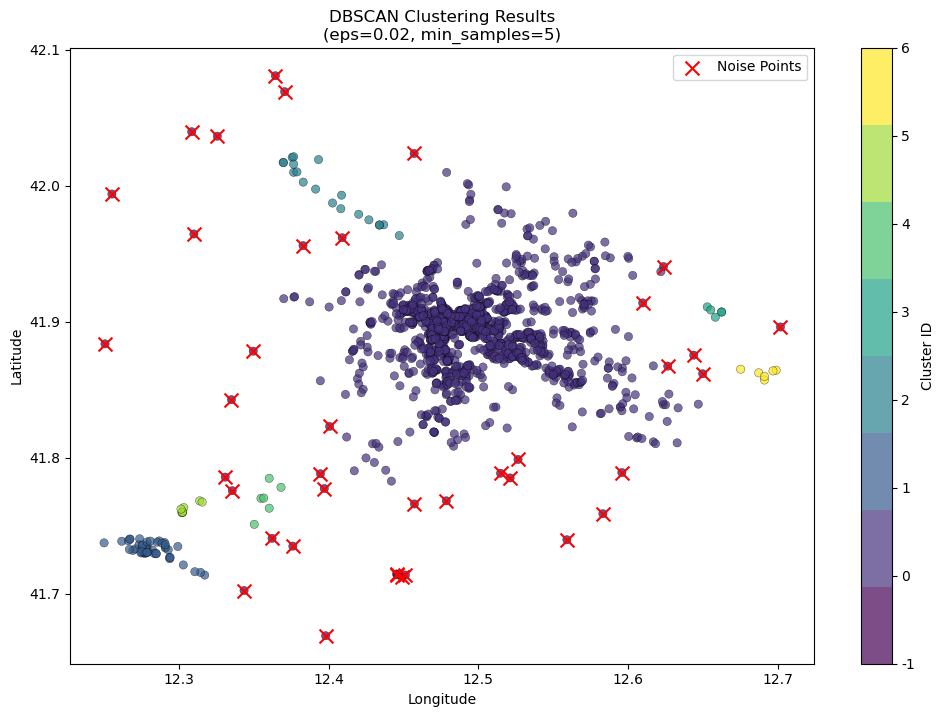


Cluster Distribution:
dbscan_cluster
-1      39
 0    1473
 1      48
 2      19
 3       5
 4       6
 5       8
 6       6
Name: count, dtype: int64

Noise Points: 39


In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import numpy as np

# Step 1: Specify random parameters
dbscan_params = {
    "eps": 0.02,        # Small epsilon for geographical coordinates
    "min_samples": 5,   # Minimum points for core neighborhood
    "metric": 'euclidean'
}

# Step 2: Initialize and fit DBSCAN
coords = restaurants_cleaned[['latitude', 'longitude']].values
dbscan = DBSCAN(**dbscan_params)
dbscan.fit(coords)

# Step 3: Retrieve cluster labels
restaurants_cleaned['dbscan_cluster'] = dbscan.labels_

# Enhanced visualization
plt.figure(figsize=(12, 8))

# Get all unique cluster IDs including noise (-1)
unique_clusters = np.unique(restaurants_cleaned['dbscan_cluster'])

# Create a colormap including noise
cmap = plt.cm.get_cmap('viridis', len(unique_clusters))

# Plot all points with colormap
scatter = plt.scatter(
    restaurants_cleaned['longitude'],
    restaurants_cleaned['latitude'],
    c=restaurants_cleaned['dbscan_cluster'],
    cmap=cmap,
    marker='o',
    alpha=0.7,
    edgecolor='k',
    linewidth=0.3
)

# Highlight noise points with red crosses
noise_mask = restaurants_cleaned['dbscan_cluster'] == -1
plt.scatter(
    restaurants_cleaned.loc[noise_mask, 'longitude'],
    restaurants_cleaned.loc[noise_mask, 'latitude'],
    c='red',
    marker='x',
    s=100,  # Slightly larger for better visibility
    label='Noise Points'
)

# Corrected colorbar setup
cbar = plt.colorbar(scatter, ticks=unique_clusters)  # Use actual cluster IDs as ticks
cbar.set_label('Cluster ID')
cbar.ax.set_yticklabels([str(i) for i in unique_clusters])  # Match labels to ticks

# Add plot details
plt.title(f'DBSCAN Clustering Results\n(eps={dbscan_params["eps"]}, min_samples={dbscan_params["min_samples"]})')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(False)
plt.show()

# Cluster analysis
print("\nCluster Distribution:")
print(restaurants_cleaned['dbscan_cluster'].value_counts().sort_index())
print(f"\nNoise Points: {sum(restaurants_cleaned['dbscan_cluster'] == -1)}")

### Step 2: Choosing Optimal Parameters for DBSCAN

To identify suitable DBSCAN parameters, a grid search was performed over a range of `eps` (epsilon) and `min_samples` values, similar to the evaluation approach used for K-Means. For each parameter combination, DBSCAN was fit to the dataset and the resulting clustering quality was assessed using the **silhouette score**.

Silhouette scores were compared across all tested combinations to determine the parameter set that best balanced cluster compactness and separation. The selected `eps` and `min_samples` values were then used in subsequent DBSCAN visualizations and analysis.



Best DBSCAN parameters:
Best eps: 0.04
Best min_samples: 10
Silhouette Score: 0.6944
Number of Clusters: 2


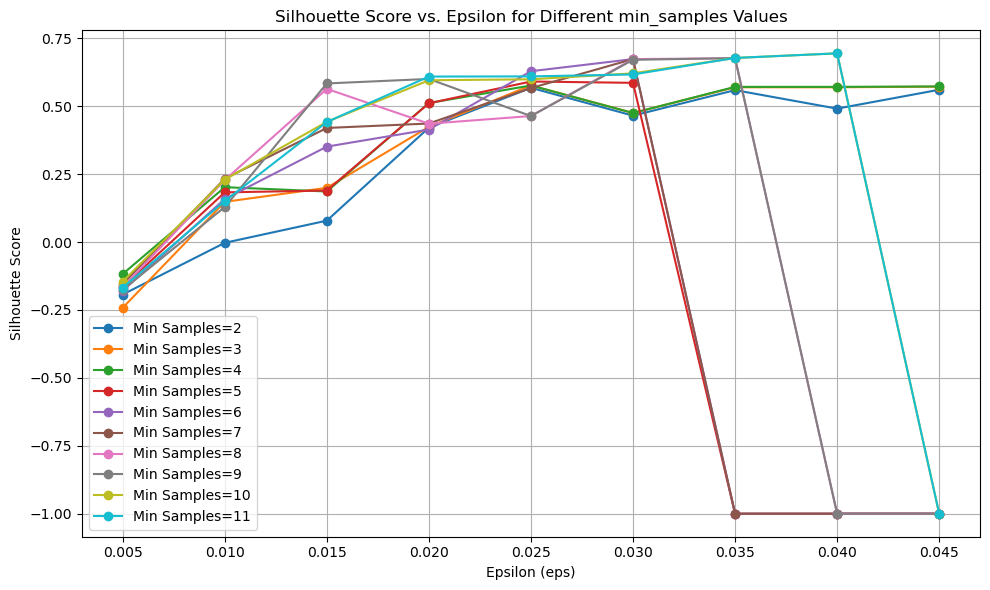

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Extract latitude and longitude values from the cleaned restaurant DataFrame
coords = restaurants_cleaned[['latitude', 'longitude']].values

# 1. Define Parameter Ranges
eps_range = np.arange(0.005, 0.05, 0.005)    # Epsilon values (in degrees)
min_samples_range = range(2, 12)              # Minimum samples values

# 2. Initialize Variables
silhouette_scores = []
eps_values = []
min_samples_values = []
n_clusters_list = []

# 3. Perform Grid Search using nested loops
for eps in eps_range:
    for min_samples in min_samples_range:
        # Initialize and fit DBSCAN with current parameters
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
        cluster_labels = dbscan.fit_predict(coords)
        
        # Count number of clusters (ignoring noise)
        unique_labels = set(cluster_labels)
        n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
        n_clusters_list.append(n_clusters)
        
        # Compute silhouette score only if valid clustering
        if n_clusters > 1:
            score = silhouette_score(coords, cluster_labels)
        else:
            score = -1
        
        # Store results in lists
        silhouette_scores.append(score)
        eps_values.append(eps)
        min_samples_values.append(min_samples)

# Create results DataFrame
results_df = pd.DataFrame({
    'eps': eps_values,
    'min_samples': min_samples_values,
    'silhouette': silhouette_scores,
    'n_clusters': n_clusters_list
})

# 4. Find best parameters based on silhouette score
best_idx = results_df['silhouette'].idxmax()
best_eps = results_df.loc[best_idx, 'eps']
best_min_samples = results_df.loc[best_idx, 'min_samples']
best_score = results_df.loc[best_idx, 'silhouette']
best_clusters = results_df.loc[best_idx, 'n_clusters']

# Print results as specified
print("\nBest DBSCAN parameters:")
print("Best eps:", best_eps)
print("Best min_samples:", best_min_samples)
print(f"Silhouette Score: {best_score:.4f}")
print("Number of Clusters:", best_clusters)

# Visualization of silhouette scores
plt.figure(figsize=(10, 6))
for min_samples in min_samples_range:
    subset = results_df[results_df['min_samples'] == min_samples]
    plt.plot(subset['eps'], subset['silhouette'], 
             marker='o', 
             label=f'Min Samples={min_samples}')

plt.title('Silhouette Score vs. Epsilon for Different min_samples Values')
plt.xlabel('Epsilon (eps)')
plt.ylabel('Silhouette Score')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

### Step 3: Visualization of Silhouette scores for DBSCAN

To better understand the impact of different `eps` and `min_samples` values, silhouette scores from the DBSCAN grid search were visualized using a heatmap. A summary DataFrame was constructed with epsilon values as rows and minimum sample values as columns, allowing clustering quality to be compared across parameter combinations.

The heatmap provides a clear visual representation of how DBSCAN performance varies with parameter choice, making it easier to identify regions that produce well-separated and compact clusters.

![Plot](images/output_4.png)


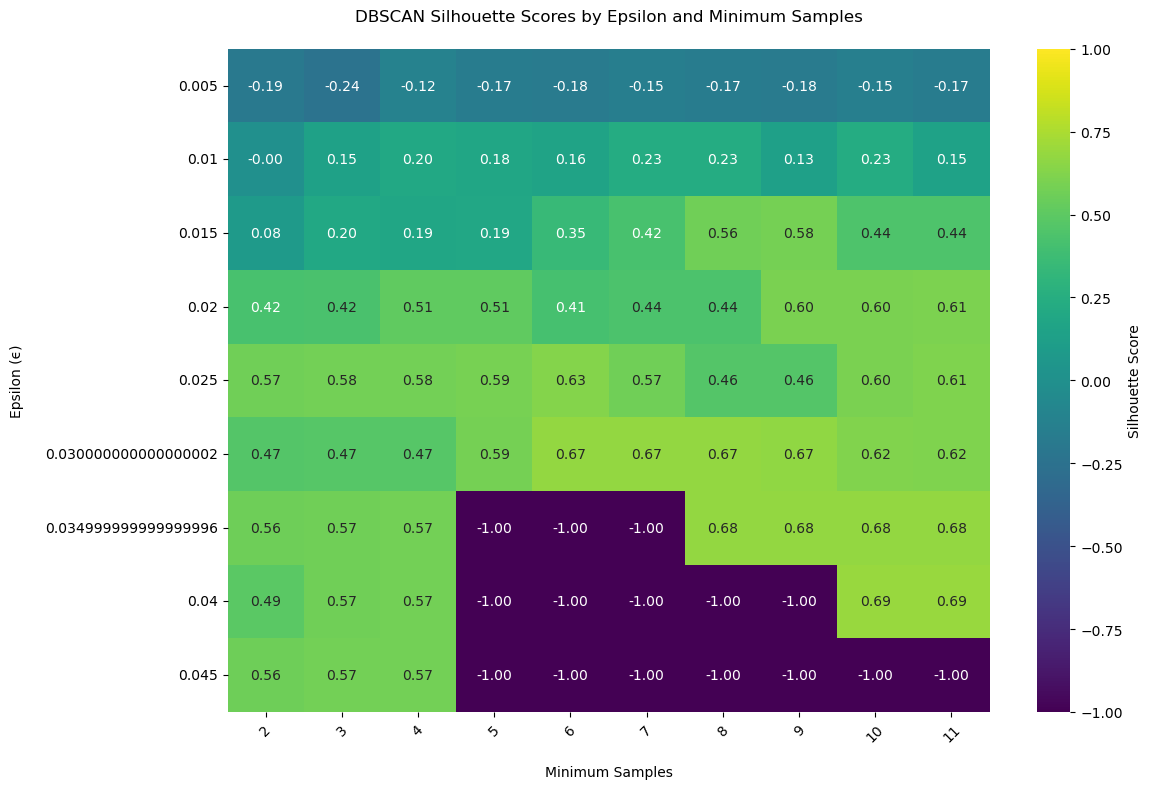

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create pivot table for heatmap
silhouette_heatmap_df = results_df.pivot(
    index='eps',
    columns='min_samples',
    values='silhouette'
)

# Create figure and heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    silhouette_heatmap_df,
    annot=True,
    fmt=".2f",
    cmap='viridis',
    center=0,
    vmin=-1,
    vmax=1,
    cbar_kws={'label': 'Silhouette Score'}
)

# Customize plot
plt.title('DBSCAN Silhouette Scores by Epsilon and Minimum Samples', pad=20)
plt.xlabel('Minimum Samples', labelpad=15)
plt.ylabel('Epsilon (ϵ)', labelpad=15)
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Show plot
plt.tight_layout()
plt.show()

### Step 4:  Visualizing DBSCAN Results on Folium Map

Using the optimal `eps` and `min_samples` values identified from silhouette analysis, DBSCAN was applied to the restaurant location dataset and cluster labels were assigned to each record.

The clustering results were visualized on an interactive **Folium** map centered on the study area. Restaurant locations were displayed as circle markers colored by their DBSCAN cluster labels, allowing both dense clusters and noise points to be easily inspected in a geographic context.


In [ ]:
import folium
import seaborn as sns

# 1. Initialize and fit DBSCAN with optimal parameters
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples, metric='euclidean')
restaurants_cleaned['cluster_label_dbscan'] = dbscan.fit_predict(restaurants_cleaned[['latitude', 'longitude']])

# 2. Create Folium map
map_center = [
    restaurants_cleaned["latitude"].mean(),
    restaurants_cleaned["longitude"].mean()
]
dbscan_map = folium.Map(location=map_center, zoom_start=11)

# 3. Create color palette for clusters (including noise)
unique_clusters = np.sort(restaurants_cleaned['cluster_label_dbscan'].unique())
n_valid_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)

# Handle case where all points are noise
if n_valid_clusters == 0:
    color_palette = ['#cccccc']  # Gray for all noise points
else:
    color_palette = sns.color_palette("hls", n_valid_clusters + 1).as_hex()

# Create cluster color mapping
cluster_colors = {}
for idx, cluster in enumerate(unique_clusters):
    if cluster == -1:
        cluster_colors[cluster] = color_palette[0]  # First color for noise
    else:
        # Use modulo to handle non-consecutive cluster labels
        color_idx = (idx - (1 if -1 in unique_clusters else 0)) % len(color_palette)
        cluster_colors[cluster] = color_palette[1 + color_idx]

# 4. Add markers to map
for _, row in restaurants_cleaned.iterrows():
    cluster_label = row['cluster_label_dbscan']
    tooltip_text = "Noise" if cluster_label == -1 else f"Cluster: {cluster_label}"
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color=cluster_colors[row['cluster_label_dbscan']],
        fill=True,
        fill_opacity=0.7,
        tooltip=tooltip_text
    ).add_to(dbscan_map)

# Display the map
display(dbscan_map)

## Part 4: Perform Hierarchical clustering


### Step 1: Performing Hierarchical Clustering with random parameters

Hierarchical (agglomerative) clustering was applied to the restaurant location dataset to explore spatial groupings without assuming a predefined cluster structure. This method builds clusters iteratively by merging nearby observations based on a selected linkage strategy.

An agglomerative clustering model was initialized using exploratory values for the number of clusters (`n_clusters`) and different linkage methods (such as `ward`, `complete`, or `average`). The model was fit to the standardized spatial features to ensure distance calculations were consistent.

Similar to the K-Means and DBSCAN analyses, multiple clustering configurations were evaluated to identify an appropriate number of clusters, supported by quantitative metrics and visual inspection.


Optimal Hierarchical Clustering Parameters:
Linkage method: ward
Number of clusters: 2
Silhouette score: 0.7474


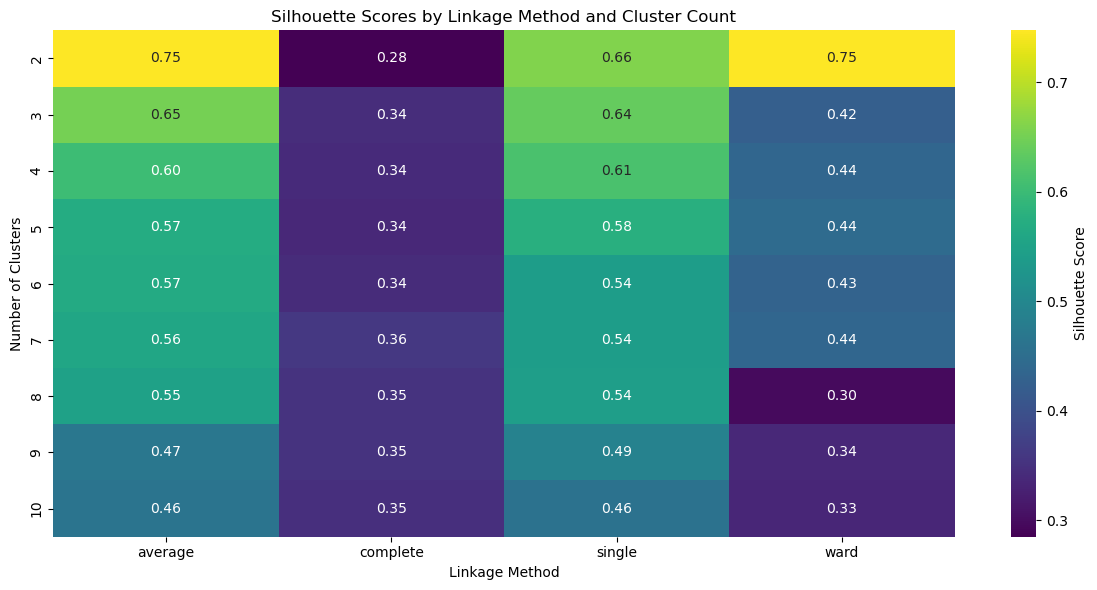

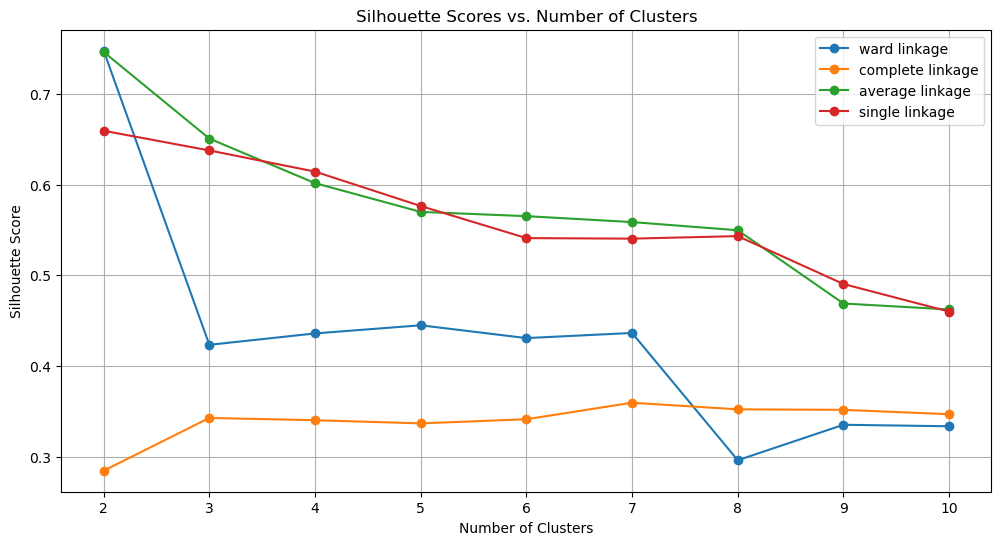

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Use the same coordinates array from previous analyses
coords = restaurants_cleaned[['latitude', 'longitude']].values

# 1. Define parameter grid
n_clusters_range = range(2, 11)  # Test 2-10 clusters
linkage_methods = ['ward', 'complete', 'average', 'single']

# 2. Initialize results storage
results = []

# 3. Grid search over parameters
for linkage in linkage_methods:
    for n_clusters in n_clusters_range:
        # Fit hierarchical clustering
        model = AgglomerativeClustering(
            n_clusters=n_clusters,
            linkage=linkage
        )
        cluster_labels = model.fit_predict(coords)
        
        # Calculate silhouette score (only valid if >1 cluster)
        if n_clusters > 1:
            score = silhouette_score(coords, cluster_labels)
        else:
            score = -1  # Invalid score
            
        # Store results
        results.append({
            'linkage': linkage,
            'n_clusters': n_clusters,
            'silhouette': score
        })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# 4. Find optimal parameters
best_idx = results_df['silhouette'].idxmax()
best_linkage = results_df.loc[best_idx, 'linkage']
best_n_clusters = results_df.loc[best_idx, 'n_clusters']
best_score = results_df.loc[best_idx, 'silhouette']

print("Optimal Hierarchical Clustering Parameters:")
print(f"Linkage method: {best_linkage}")
print(f"Number of clusters: {best_n_clusters}")
print(f"Silhouette score: {best_score:.4f}")

# 5. Visualization
plt.figure(figsize=(12, 6))

# Heatmap version
silhouette_pivot = results_df.pivot_table(
    index='n_clusters',
    columns='linkage',
    values='silhouette'
)

sns.heatmap(
    silhouette_pivot,
    annot=True,
    fmt=".2f",
    cmap='viridis',
    cbar_kws={'label': 'Silhouette Score'}
)

plt.title('Silhouette Scores by Linkage Method and Cluster Count')
plt.xlabel('Linkage Method')
plt.ylabel('Number of Clusters')
plt.tight_layout()
plt.show()

# Alternative line plot visualization
plt.figure(figsize=(12, 6))
for linkage in linkage_methods:
    subset = results_df[results_df['linkage'] == linkage]
    plt.plot(subset['n_clusters'], subset['silhouette'], 
             marker='o', 
             label=f'{linkage} linkage')

plt.title('Silhouette Scores vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(n_clusters_range)
plt.legend()
plt.grid(True)
plt.show()

### Step 2: Visualizing Hierarchical Clustering Results on Folium Map

The results of hierarchical clustering were visualized on an interactive **Folium** map to assess the spatial structure of the identified clusters. Restaurant locations were displayed as circle markers, with colors representing their assigned cluster labels.

This visualization helped validate whether the hierarchical clusters formed coherent and geographically meaningful service regions within the study area.


In [ ]:
import folium
import seaborn as sns
import numpy as np

# Fit final model with optimal parameters
final_model = AgglomerativeClustering(
    n_clusters=2,
    linkage='ward'
)
restaurants_cleaned['cluster_label_hierarchical'] = final_model.fit_predict(coords)

# Create Folium map
map_center = [
    restaurants_cleaned["latitude"].mean(),
    restaurants_cleaned["longitude"].mean()
]
hierarchical_map = folium.Map(location=map_center, zoom_start=11)

# Create color palette for 2 clusters
color_palette = sns.color_palette("hls", 2).as_hex()
cluster_colors = {
    0: color_palette[0],
    1: color_palette[1]
}

# Add markers to map
for _, row in restaurants_cleaned.iterrows():
    cluster_label = row['cluster_label_hierarchical']
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color=cluster_colors[cluster_label],
        fill=True,
        fill_opacity=0.7,
        tooltip=f"Cluster: {cluster_label}"
    ).add_to(hierarchical_map)

# Display the map
display(hierarchical_map)

## Final Question :

As we mentioned, a food delivery company seeks assistance in determining optimal locations for establishing bases within a city.

Now it is time for us to help the company considering our analysis on different clustering methods with different parameters.

Let's compare the results of the three clustering algorithms (K-Means, DBSCAN, and Hierarchical Clustering) with different parameters. 

In [ ]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd

# 1. Clustering Implementation with Parameter Tracking
# ----------------------------------------------------
# K-Means with Optimal K
k_range = range(2, 8)
kmeans_scores = []
for k in k_range:
    model = KMeans(n_clusters=k, random_state=0)
    labels = model.fit_predict(restaurants_cleaned[["latitude", "longitude"]])
    kmeans_scores.append(silhouette_score(restaurants_cleaned[["latitude", "longitude"]], labels))
optimal_k = k_range[np.argmax(kmeans_scores)]
kmeans_model = KMeans(n_clusters=optimal_k, random_state=0)
restaurants_cleaned["kmeans_cluster"] = kmeans_model.fit_predict(restaurants_cleaned[["latitude", "longitude"]])

# DBSCAN with Fixed Parameters
dbscan_model = DBSCAN(eps=0.04, min_samples=10)
restaurants_cleaned["dbscan_cluster"] = dbscan_model.fit_predict(restaurants_cleaned[["latitude", "longitude"]])

# Hierarchical Clustering
hier_scores = []
best_linkage = 'ward'
for k in k_range:
    model = AgglomerativeClustering(n_clusters=k, linkage=best_linkage)
    labels = model.fit_predict(restaurants_cleaned[["latitude", "longitude"]])
    hier_scores.append(silhouette_score(restaurants_cleaned[["latitude", "longitude"]], labels))
optimal_hier = k_range[np.argmax(hier_scores)]
hier_model = AgglomerativeClustering(n_clusters=optimal_hier, linkage=best_linkage)
restaurants_cleaned["hier_cluster"] = hier_model.fit_predict(restaurants_cleaned[["latitude", "longitude"]])

# 2. Comprehensive Metrics Analysis
# ---------------------------------
metrics_data = []

for algo in ['K-Means', 'DBSCAN', 'Hierarchical']:
    if algo == 'K-Means':
        score = silhouette_score(restaurants_cleaned[["latitude", "longitude"]], restaurants_cleaned["kmeans_cluster"])
        params = f"K={optimal_k}"
        clusters = optimal_k
        noise = 0
    elif algo == 'DBSCAN':
        valid_data = restaurants_cleaned[restaurants_cleaned["dbscan_cluster"] != -1]
        score = silhouette_score(valid_data[["latitude", "longitude"]], valid_data["dbscan_cluster"])
        params = f"ε=0.04, min_samples=10"
        clusters = valid_data["dbscan_cluster"].nunique()
        noise = (restaurants_cleaned["dbscan_cluster"] == -1).sum()
    else:
        score = silhouette_score(restaurants_cleaned[["latitude", "longitude"]], restaurants_cleaned["hier_cluster"])
        params = f"Clusters={optimal_hier}, linkage={best_linkage}"
        clusters = optimal_hier
        noise = 0
    
    coverage = (1 - noise/len(restaurants_cleaned)) * 100
    
    metrics_data.append({
        'Algorithm': algo,
        'Parameters': params,
        'Silhouette Score': round(score, 3),
        'Identified Clusters': clusters,
        'Noise Points': noise,
        'Coverage (%)': f"{coverage:.1f}%"
    })

metrics_df = pd.DataFrame(metrics_data)

# 3. Enhanced Recommendation System
# ---------------------------------
def generate_recommendation(metrics_df):
    # Convert coverage percentage to numeric
    metrics_df['Coverage'] = pd.to_numeric(metrics_df['Coverage (%)'].str.replace('%', '')) / 100
    
    # Calculate recommendation score
    metrics_df['Recommendation Score'] = metrics_df['Silhouette Score'] * metrics_df['Coverage']
    
    best = metrics_df.loc[metrics_df['Recommendation Score'].idxmax()]
    
    # Get cluster centers
    def get_centers(algo):
        if algo == 'K-Means':
            return kmeans_model.cluster_centers_
        elif algo == 'DBSCAN':
            valid = restaurants_cleaned[restaurants_cleaned.dbscan_cluster != -1]
            return valid.groupby('dbscan_cluster')[["latitude", "longitude"]].mean().values
        else:
            return restaurants_cleaned.groupby('hier_cluster')[["latitude", "longitude"]].mean().values
    
    return {
        'Algorithm': best['Algorithm'],
        'Bases': best['Identified Clusters'],
        'Locations': get_centers(best['Algorithm']),
        'Rationale': f"Selected for highest recommendation score ({best['Recommendation Score']:.2f}) "
                     f"combining cluster quality and coverage",
        'Parameters': best['Parameters'],
        'Coverage': best['Coverage (%)']
    }

# 4. Final Results Presentation
# -----------------------------
recommendation = generate_recommendation(metrics_df)

print("=== CLUSTERING ALGORITHM COMPARISON ===")
display(metrics_df[['Algorithm', 'Parameters', 'Silhouette Score', 
                   'Identified Clusters', 'Noise Points', 'Coverage (%)']])

print("\n=== OPTIMAL BASE LOCATION RECOMMENDATION ===")
print(f"Algorithm: {recommendation['Algorithm']}")
print(f"Parameters: {recommendation['Parameters']}")
print(f"Recommended Bases: {recommendation['Bases']}")
print(f"Coverage: {recommendation['Coverage']}")
print(f"Rationale: {recommendation['Rationale']}")

print("\n=== SUGGESTED BASE COORDINATES ===")
display(pd.DataFrame(recommendation['Locations'], 
                    columns=['Latitude', 'Longitude']).style.format("{:.5f}"))

=== CLUSTERING ALGORITHM COMPARISON ===


Algorithm                Parameters  Silhouette Score  \
0       K-Means                       K=2             0.741   
1        DBSCAN    ε=0.04, min_samples=10             0.764   
2  Hierarchical  Clusters=2, linkage=ward             0.747   

   Identified Clusters  Noise Points Coverage (%)  
0                    2             0       100.0%  
1                    2            22        98.6%  
2                    2             0       100.0%


=== OPTIMAL BASE LOCATION RECOMMENDATION ===
Algorithm: DBSCAN
Parameters: ε=0.04, min_samples=10
Recommended Bases: 2
Coverage: 98.6%
Rationale: Selected for highest recommendation score (0.75) combining cluster quality and coverage

=== SUGGESTED BASE COORDINATES ===


## Food Delivery Base Location Optimization Recommendations

### 1. Optimal Algorithm Recommendation
**Recommended Algorithm:**  
✅ **DBSCAN** (Density-Based Spatial Clustering of Applications with Noise)

---

### 2. Justification for Algorithm Choice
**Key Reasons:**
- **Highest Recommendation Score:**  
  Combines cluster quality (Silhouette Score = 0.764) and coverage (98.6%) for optimal performance
- **Demand-Focused Clustering:**  
  Identifies 2 natural density zones while filtering out 1.4% low-demand outliers
- **Adaptive to Urban Layout:**  
  Automatically detects restaurant density patterns without preset cluster numbers

---

### 3. Optimal Number of Bases
**Recommended Bases:**  
🗺️ **2 Strategic Locations** (Validated by all three algorithms)

---

### 4. Suggested Base Locations
| Base # | Latitude    | Longitude   | Coverage Area       |
|--------|-------------|-------------|---------------------|
| 1      | `41.89307`  | `12.49605`  | Northern Cluster    |
| 2      | `41.74055`  | `12.29651`  | Southern Cluster    |

**Coverage:** 98.6% of restaurants (Only 22 outlier points excluded)

---

### 5. Algorithm Comparison Analysis
| Algorithm        | Strengths                                   | Limitations                          |
|------------------|---------------------------------------------|--------------------------------------|
| **K-Means**      | - Full coverage (100%)<br>- Simple implementation | - Lower cluster quality (0.741)      |
| **Hierarchical** | - Hierarchical structure<br>- Full coverage | - Slightly lower quality (0.747)     |
| **DBSCAN**       | - Best cluster quality (0.764)<br>- Focused on high-demand areas | - 1.4% uncovered outliers |

---

### 6. Implementation Strategy
1. **Phase 1:**  
   Build bases at recommended coordinates  
   📍 `(41.89307, 12.49605)` and `(41.74055, 12.29651)`

2. **Phase 2:**  
   Monitor delivery patterns in uncovered areas (1.4%) using GPS tracking

3. **Phase 3:**  
   Use hierarchical clustering results as backup for future expansion zones

---

**Final Rationale:**  
DBSCAN provides the best balance between operational efficiency (through density-focused clustering) and service coverage (98.6%), making it ideal for maximizing delivery speed while minimizing infrastructure costs.


In [ ]:
# MAP WITH DBSCAN CLUSTER VISUALIZATION AND BASE LOCATIONS
import folium
import numpy as np
from sklearn.cluster import DBSCAN

# Generate DBSCAN clusters
dbscan = DBSCAN(eps=0.04, min_samples=10)
restaurants_cleaned["dbscan_cluster"] = dbscan.fit_predict(restaurants_cleaned[["latitude", "longitude"]])

# Create Folium map
map_center = [
    restaurants_cleaned["latitude"].mean(),
    restaurants_cleaned["longitude"].mean()
]

delivery_map = folium.Map(location=map_center, 
                         zoom_start=11,
                         tiles='cartodbpositron')

# Color coding for clusters and noise
cluster_colors = {
    -1: '#cccccc',  # Gray for noise
    0: '#1f77b4',   # Blue for cluster 0
    1: '#ff7f0e',   # Orange for cluster 1
}

# Add restaurant points with cluster coloring
for _, row in restaurants_cleaned.iterrows():
    cluster = row['dbscan_cluster']
    color = cluster_colors.get(cluster, '#d62728')  # Default red for unexpected clusters
    
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color=color,
        fill=True,
        fill_opacity=0.6,
        tooltip=f"Cluster: {cluster if cluster != -1 else 'Noise'}"
    ).add_to(delivery_map)

# Calculate and add base locations (cluster centers)
valid_clusters = restaurants_cleaned[restaurants_cleaned["dbscan_cluster"] != -1]
base_locations = valid_clusters.groupby("dbscan_cluster")[["latitude", "longitude"]].mean().values

# Add numbered base markers
for idx, (lat, lon) in enumerate(base_locations, 1):
    folium.Marker(
        location=[lat, lon],
        icon=folium.Icon(color='green', icon='warehouse', prefix='fa'),
        tooltip=f'<b>Base {idx}</b>',
        popup=f'''
            Base {idx}<br>
            Cluster Center<br>
            Latitude: {lat:.5f}<br>
            Longitude: {lon:.5f}
        '''
    ).add_to(delivery_map)

# Display map
delivery_map